In [7]:
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'
FIG_SIZE = (20, 30)

In [8]:
import math
import itertools
import os
import numpy as np
import skimage.io as io
import pandas as pd
from scipy import ndimage
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [9]:
def hsv_to_rgb(h, s, v):
    h -= math.floor(h)
    h = h * 6
    if h < 1:
        [r, g, b] = [1, h, 0]
    elif h < 2:
        [r, g, b] = [2 - h, 1, 0]
    elif h < 3:
        [r, g, b] = [0, 1, h - 2]
    elif h < 4:
        [r, g, b] = [0, 4 - h, 1]
    elif h < 5:
        [r, g, b] = [h - 4, 0, 1]
    else:
        [r, g, b] = [1, 0, 6 - h]
    return [((r - 0.5) * s + 0.5) * v, ((g - 0.5) * s + 0.5) * v, ((b - 0.5) * s + 0.5) * v]

hash_colorize = np.array([[0, 0, 0] if i == 0 else
                              hsv_to_rgb(((i + 1) % 17)/17,
                                         ((i + 1) % 3)/3 / 2 + 0.5,
                                         ((i + 1) % 5)/5 * 2/3 + 1/3)
                          for i in range(256)])

def mask_to_edges(mask):
    mask_edges = np.zeros(mask.shape).astype(np.uint8)
    for ii in range(1, mask.max() + 1):
        submask = mask.copy()
        submask[submask != ii] = 0
        submask[submask == ii] = 1
        submask_edges = submask - ndimage.binary_erosion(submask, structure=np.ones((5,5)))
        mask_edges += submask_edges * ii
    return mask_edges

def visualize_mask(mask, img=None, edges=True, fill=True):
    if fill:
        if img is None:
            img = mask.copy()
            img[img > 0] = 1
        img = np.multiply(np.repeat(np.reshape(img, img.shape + (1,)), 3, 2), hash_colorize[mask])
    else:
        if img is None:
            img = np.zeros(mask.shape)
        img = np.repeat(np.reshape(img, img.shape + (1,)), 3, 2)
    if edges:
        img = np.clip(img + hash_colorize[mask_to_edges(mask)], 0, 1)
    return img

In [10]:
def remove_alpha(img):
    return img[:, :, 0:3]

def grayscale(img):
    if img.shape[2] == 4:
        img = remove_alpha(img)
    return img.mean(axis=2)

def normalize(img):
    if len(img.shape) == 3 and img.shape[2] == 4:
        img = remove_alpha(img)
    img_max = img.max()
    img_min = img.min()
    img = (img - img_min) / (img_max - img_min)
    return img

def flatten_masks(masks):
    mask = np.zeros(masks[0].shape).astype(np.uint8)
    for ii, submask in enumerate(masks, 1):
        submask[submask > 0] = 1
        mask += submask * ii
    return mask

class NucleiDataset():
    def __init__(self, path, transform = None):
        self.path = path
        self.transform = transform
        self.ids = next(os.walk(path))[1]

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id = self.ids[idx]
        return self.get(id)
    
    def get(self, id):
        path = self.path + id
        image = io.imread(path + "/images/" + id + ".png")
        masks = []
        mask_path = path + "/masks/"
        for mask in next(os.walk(mask_path))[2]:
            masks.append(io.imread(mask_path + mask))
        sample = {"id": id, "image": image, "masks": masks}
        if self.transform:
            self.transform(sample)
        return sample        

def normalize_and_flatten(sample):
    sample["image"] = normalize(grayscale(sample["image"]))
    sample["mask"] = flatten_masks(sample["masks"])
    del sample["masks"]

train_set = NucleiDataset(TRAIN_PATH)
test_set = NucleiDataset(TEST_PATH)

In [11]:
def plot_image(fig, sample, plot_spec):
    image = sample["image"]

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=plot_spec, wspace=0.1, hspace=0.1)
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j == 0:
            ax.imshow(normalize(image))
        else:
            ax.imshow(visualize_mask(flatten_masks(sample["masks"]), img=normalize(grayscale(image))))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

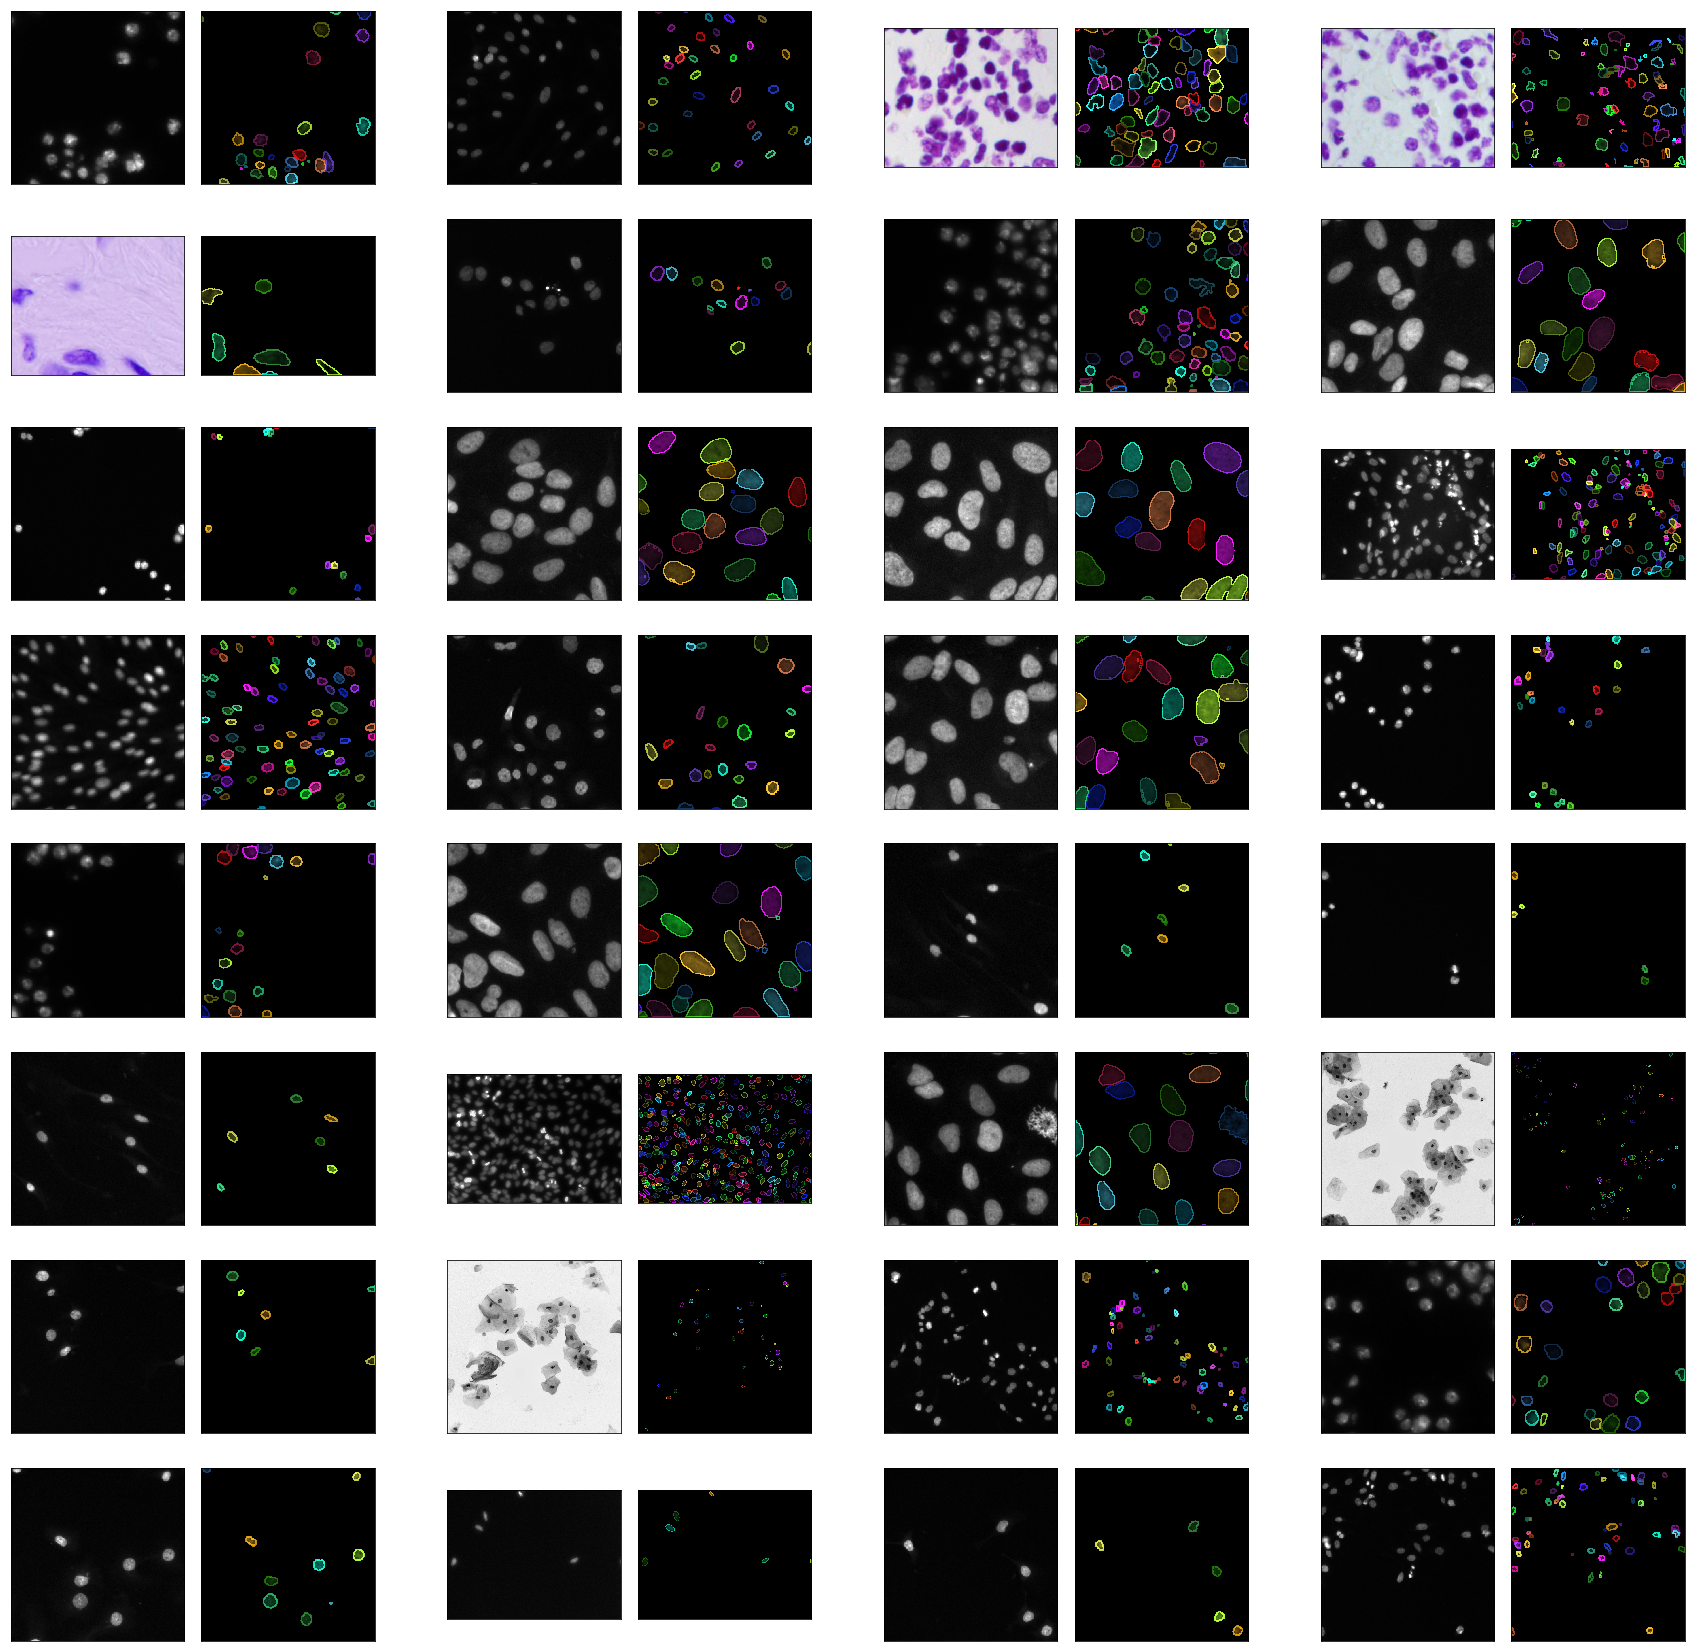

In [12]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(8, 4, wspace=0.2, hspace=0.2)

for (i, sample) in enumerate(itertools.islice(train_set, 32)):
    plot_image(fig, sample, outer[i])

In [13]:
image_ids = []
image_sizes = []
for sample in train_set:
    image = sample["image"]
    image_ids.append(sample["id"])
    image_sizes.append([image.shape[1], image.shape[0]])
image_ids = np.array(image_ids)
image_sizes = np.array(image_sizes)

In [14]:
images = np.rec.fromarrays((image_ids, image_sizes[:, 0], image_sizes[:, 1]),
                           dtype=[('id', image_ids.dtype), ('w', int), ('h', int)])
pd.DataFrame.from_records(images, index=('id'))

,w,h
id,,
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552,256,256
003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1,256,256
00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e,320,256
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed,320,256
01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf,320,256
0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21,256,256
0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426,256,256
02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339,360,360
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776,256,256


In [15]:
print("Range: (%d - %d) x (%d - %d)" % (images.w.min(), images.w.max(), images.h.min(), images.h.max()))
print("Mean: %d x %d" % (images.w.mean(), images.h.mean()))
aspect_ratio = images.w / images.h
def aspect_ratio_to_str(ratio):
    if ratio >= 1:
        return "%f : 1" % (ratio,)
    else:
        return "1 : %f" % (1 / ratio,)
print("Aspect ratio range: (%s) - (%s)" % (aspect_ratio_to_str(aspect_ratio.min()), aspect_ratio_to_str(aspect_ratio.max())))

Range: (256 - 1388) x (256 - 1040)
Mean: 378 x 333
Aspect ratio range: (1.000000 : 1) - (2.109453 : 1)


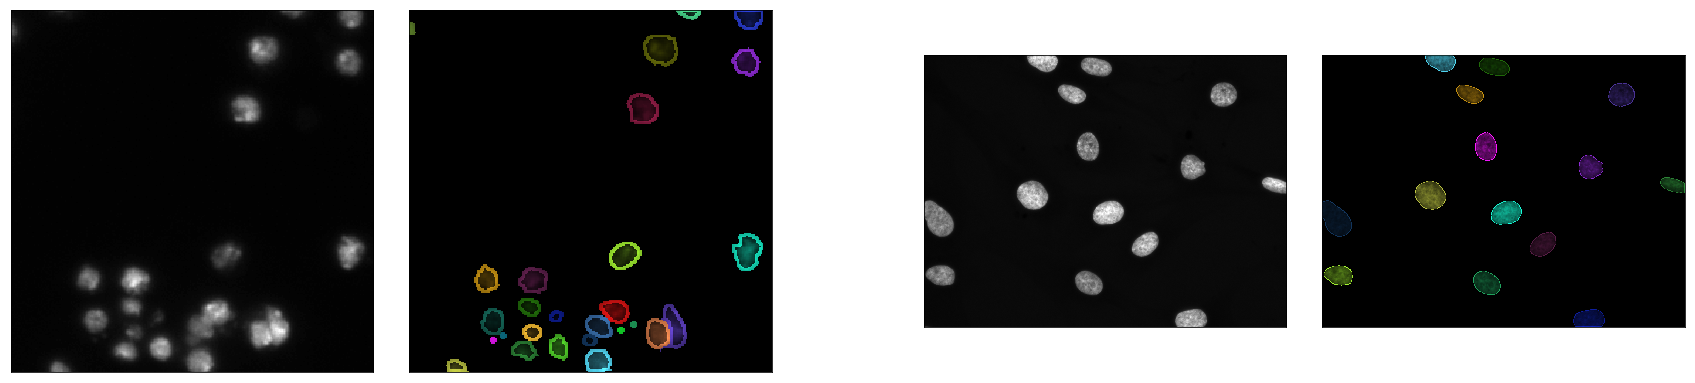

In [16]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

smallest_image = images[(images.w * images.h).argmin()]
biggest_image = images[(images.w * images.h).argmax()]

plot_image(fig, train_set.get(smallest_image.id), outer[0])
plot_image(fig, train_set.get(biggest_image.id), outer[1])

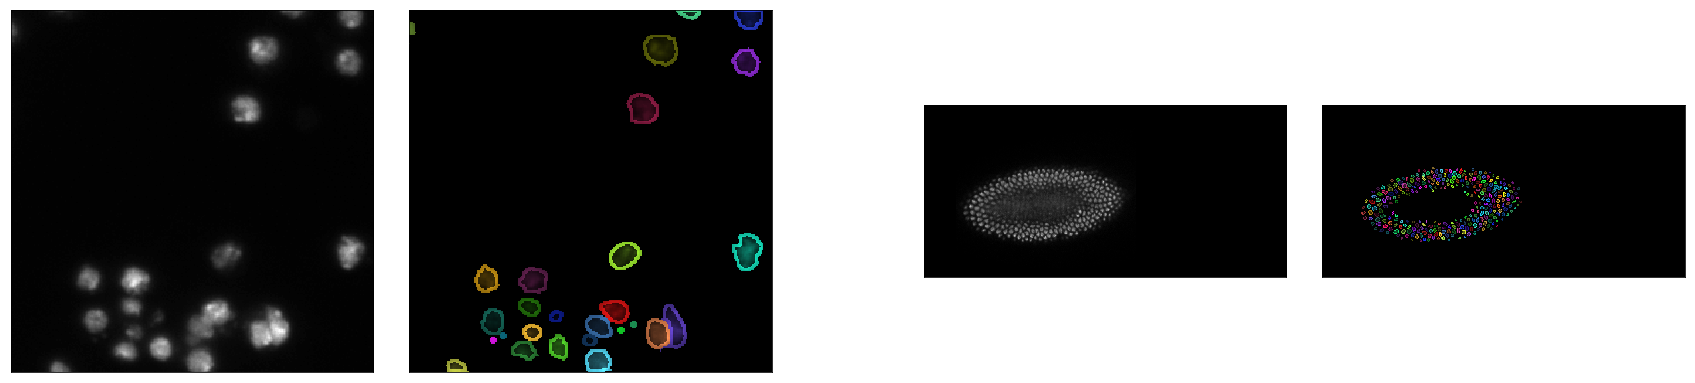

In [17]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

lowest_aspect_image = images[(images.w / images.h).argmin()]
highest_aspect_image = images[(images.w / images.h).argmax()]

plot_image(fig, train_set.get(lowest_aspect_image.id), outer[0])
plot_image(fig, train_set.get(highest_aspect_image.id), outer[1])

In [18]:
mask_ids = []
mask_idcs = []
mask_bounds = []
mask_pixel_counts = []
mask_overlap_counts = []
for sample in train_set:
    image = sample["image"]
    accumulated_mask = np.zeros(image.shape[0:len(image.shape)-1])
    for (mask_idx, mask) in enumerate(sample["masks"]):
        mask_ids.append(sample["id"])
        mask_idcs.append(mask_idx)
        x_positions = np.any(mask, axis=0).nonzero()[0]
        y_positions = np.any(mask, axis=1).nonzero()[0]
        mask_bounds.append([int(x_positions.min()), int(y_positions.min()), int(x_positions.max()), int(y_positions.max())])
        mask_pixel_counts.append(int(np.count_nonzero(mask)))
        mask_overlap_counts.append(int(np.count_nonzero(accumulated_mask * mask)))
        accumulated_mask += mask

Cell Nuclei Sizes
The table below shows, for each sample and each cell nucleus mask in that sample, the bounding box of the nucleus, the count of pixels in the mask, and hence the width, height, area, density and overlap with other masks.

In [19]:
mask_ids = np.array(mask_ids)
mask_idcs = np.array(mask_idcs)
mask_bounds = np.array(mask_bounds)
mask_pixel_counts = np.array(mask_pixel_counts)
mask_overlap_counts = np.array(mask_overlap_counts)
width = mask_bounds[:, 2] - mask_bounds[:, 0] + 1
height = mask_bounds[:, 3] - mask_bounds[:, 1] + 1
area = width * height
density = mask_pixel_counts / area
masks = np.rec.fromarrays((mask_ids, mask_idcs, mask_bounds[:, 0], mask_bounds[:, 1], mask_bounds[:, 2], mask_bounds[:, 3], mask_pixel_counts, width, height, area, density, mask_overlap_counts),
                          dtype=[('id', mask_ids.dtype), ('mask', int), ('x1', int), ('y1', int), ('x2', int), ('y2', int), ('count', int), ('w', int), ('h', int), ('area', int), ('density', float), ('overlap', int)])
pd.DataFrame.from_records(masks, index=('id', 'mask'))

x1   y1   x2   y2  \
id                                                 mask                       
00071198d059ba7f5914a526d124d28e6d010c92466da21... 0      46  180   63  199   
                                                   1      26  247   41  255   
                                                   2     141  164  163  183   
                                                   3      77  204   92  216   
                                                   4      72  234   91  247   
                                                   5     156  220  160  224   
                                                   6     228  158  249  184   
                                                   7     124  240  142  255   
                                                   8     122  229  132  237   
                                                   9      99  212  108  220   
                                                   10    177  208  195  241   
                                                   11    227   27  247   47   
                                                   12     57  231   61  235   
                                                   13     77  182   97  200   
                                                   14    153   59  175   80   
                                                   15    134  205  155  221   
                                                   16    167  218  183  239   
                                                   17     80  222   93  233   
                                                   18    165   18  189   40   
                                                   19      0    8    4   24   
                                                   20     99  229  111  247   
                                                   21    147  224  151  228   
                                                   22    188    0  205    7   
                                                   23     50  211   66  229   
                                                   24     64  228   68  232   
                                                   25    124  216  143  231   
                                                   26    229    0  249   14   
003cee89357d9fe13516167fd67b609a164651b21934585... 0     212   57  223   72   
                                                   1      37   66   46   75   
                                                   2      77   89   92  102   
...                                                      ...  ...  ...  ...   
ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bd... 7     179  116  194  131   
                                                   8     242  209  255  224   
                                                   9     220  183  225  187   
                                                   10     60  158   81  179   
                                                   11    208  176  216  185   
                                                   12    101  103  116  116   
ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d1... 0     181  252  242  316   
                                                   1     165  191  231  241   
                                                   2     287  342  331  359   
                                                   3     189  104  245  142   
                                                   4     246  277  314  336   
                                                   5     211   48  286  101   
                                                   6     283    0  337   36   
                                                   7      90  141  163  185   
                                                   8       0    7   15   45   
                                                   9     345   39  359   68   
                                                   10     90  236  157  289   
                                                   11    318  202  359  244   
                             

In [20]:
print("Range: (%d - %d) x (%d - %d)" % (masks.w.min(), masks.w.max(), masks.h.min(), masks.h.max()))
print("Mean: %d x %d" % (masks.w.mean(), masks.h.mean()))
aspect_ratio = masks.w / masks.h
def aspect_ratio_to_str(ratio):
    if ratio >= 1:
        return "%f : 1" % (ratio,)
    else:
        return "1 : %f" % (1 / ratio,)
print("Aspect ratio range: (%s) - (%s)" % (aspect_ratio_to_str(aspect_ratio.min()), aspect_ratio_to_str(aspect_ratio.max())))
print("Mean density within bounds: %f%%" % (100. * masks.count.sum() / (masks.w * masks.h).sum(),))
print("Mean density across all pixels: %f%%" % (100. * masks.count.sum() / (images.w * images.h).sum(),))
print("Total mask overlap: %d" % (masks.overlap.sum()))

Range: (1 - 122) x (1 - 139)
Mean: 22 x 22
Aspect ratio range: (1 : 57.000000) - (47.000000 : 1)
Mean density within bounds: 71.703497%
Mean density across all pixels: 13.405407%
Total mask overlap: 0


In [21]:
# Clip a mask out
def clip(img, mask_rec, border, pad=False):
    x1 = max(mask_rec.x1-border, 0)
    x2 = min(mask_rec.x2+border, img.shape[1])
    y1 = max(mask_rec.y1-border, 0)
    y2 = min(mask_rec.y2+border, img.shape[0])
    img = img[y1:y2, x1:x2]
    if pad:
        img = np.pad(img, ((y1-mask_rec.y1+border, mask_rec.y2+border-y2), (x1-mask_rec.x1+border, mask_rec.x2+border-x2), (0, 0)), mode='edge')
    return img

# Remove any padding added by previous clip
def reclip(img, clipped, mask_rec, border):
    x1 = max(mask_rec.x1-border, 0)
    x2 = min(mask_rec.x2+border, img.shape[1])
    y1 = max(mask_rec.y1-border, 0)
    y2 = min(mask_rec.y2+border, img.shape[0])
    clipped = clipped[y1-mask_rec.y1+border:clipped.shape[0] - mask_rec.y2-border+y2, x1-mask_rec.x1+border:clipped.shape[1] - mask_rec.x2-border+x2]
    return clipped

def plot_mask(fig, dataset, mask_rec, plot_spec):
    sample = dataset.get(mask_rec.id)
    image = sample["image"]
    mask = sample["masks"][mask_rec.mask]

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=plot_spec, wspace=0.1, hspace=0.1)
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j == 0:
            ax.imshow(clip(normalize(image), mask_rec, 5))
        else:
            ax.imshow(reclip(image,
                    visualize_mask(clip(np.expand_dims(flatten_masks(sample["masks"]), 2), mask_rec, 5, pad=True)[..., 0],
                                   img=normalize(grayscale(clip(image, mask_rec, 5, pad=True)))), mask_rec, 5))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

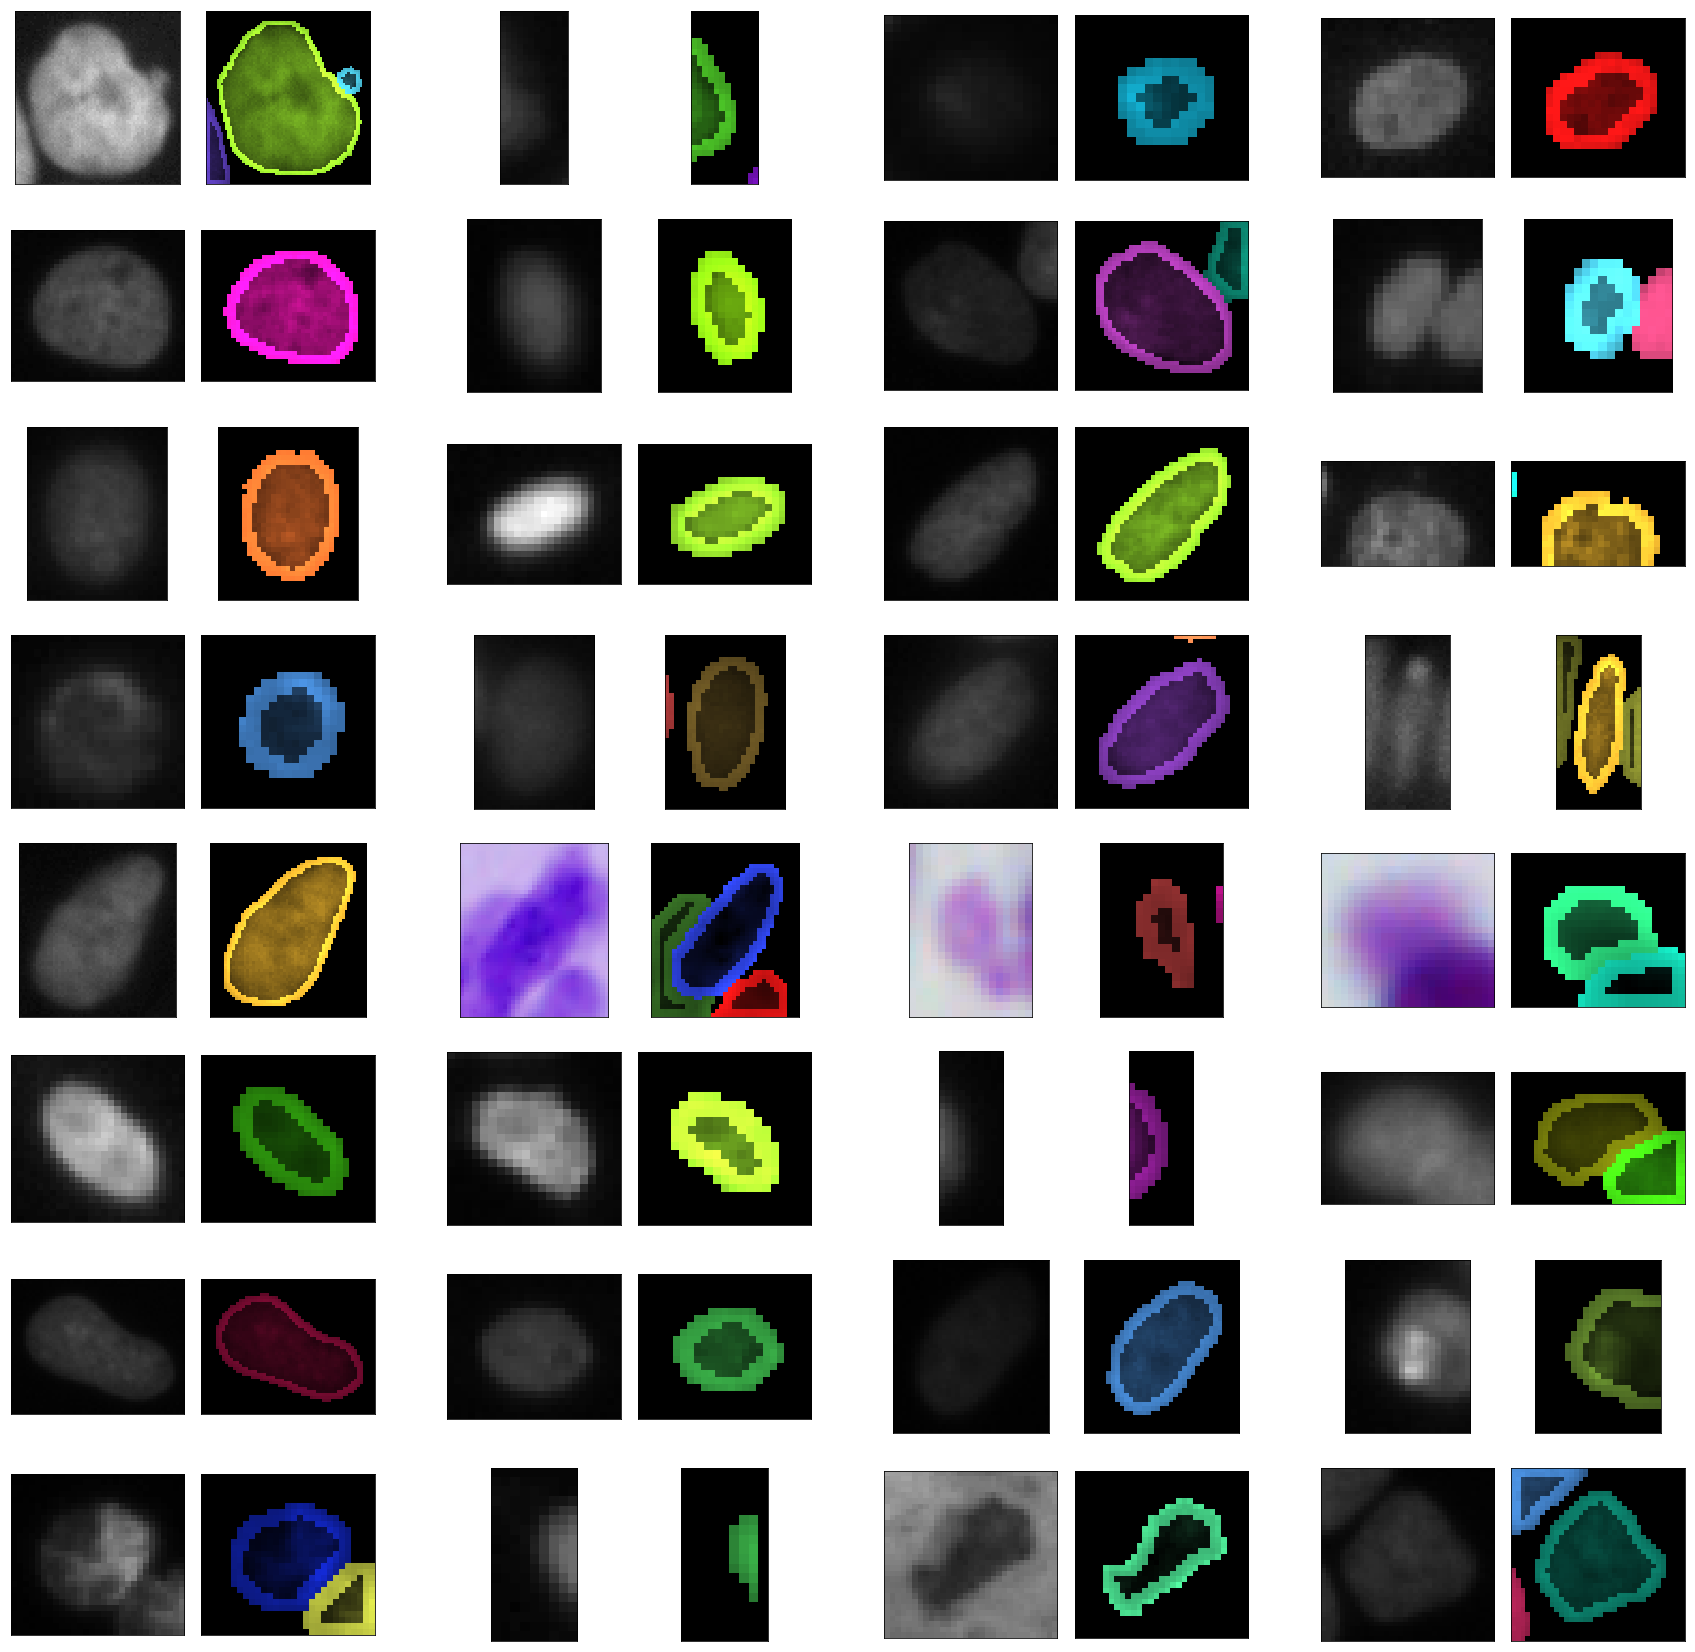

In [22]:
masks_shuffled = np.copy(masks)
np.random.shuffle(masks_shuffled)

fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(8, 4, wspace=0.2, hspace=0.2)

for (i, mask_rec) in enumerate(itertools.islice(masks_shuffled, 32)):
    plot_mask(fig, train_set, mask_rec, outer[i])

plt.show()

Here are the nuclei with the smallest and largest pixel densities in the training set. In both cases, I think these would be impossible to predict. It's possible they're actually labelling errors.

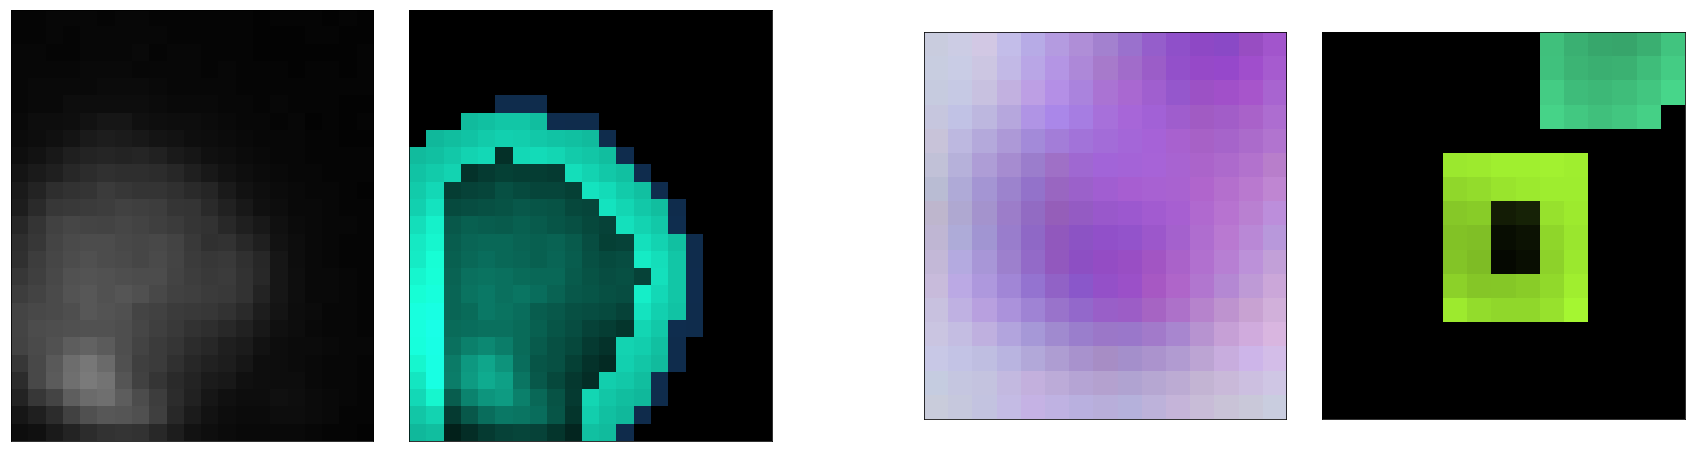

In [23]:
fig = plt.figure(figsize=(FIG_SIZE[1], FIG_SIZE[1]))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

lowest_density_mask = masks[masks.density.argmin()]
highest_density_mask = masks[masks.density.argmax()]

plot_mask(fig, train_set, lowest_density_mask, outer[0])
plot_mask(fig, train_set, highest_density_mask, outer[1])

Colors
Not all images are grayscale. Here are some statistics on color use.

In [24]:
rgba_max = np.empty((0, 4))
rgba_min = np.empty((0, 4))
rgba_mean = np.empty((0, 4))
for sample in train_set:
    image = sample["image"]
    image = image.reshape(-1, image.shape[2])/255.0
    rgba_max = np.concatenate((rgba_max, np.expand_dims(image.max(axis=0), 0)))
    rgba_min = np.concatenate((rgba_min, np.expand_dims(image.min(axis=0), 0)))
    rgba_mean = np.concatenate((rgba_mean, np.expand_dims(image.mean(axis=0), 0)))
    #np.linalg.svd(np.cov(image.T))
    
rgba_max = rgba_max.max(axis=0)
rgba_min = rgba_min.min(axis=0)
print("Maximum: ", rgba_max)
print("Minimum: ", rgba_min)
print("Mean: ", rgba_mean.mean(axis=0))
print("Alpha channel used? ", rgba_max[3] != 255 or rgba_min[3] != 255)

Maximum:  [ 1.  1.  1.  1.]
Minimum:  [ 0.  0.  0.  1.]
Mean:  [ 0.17071716  0.15513969  0.18911588  1.        ]
Alpha channel used?  True


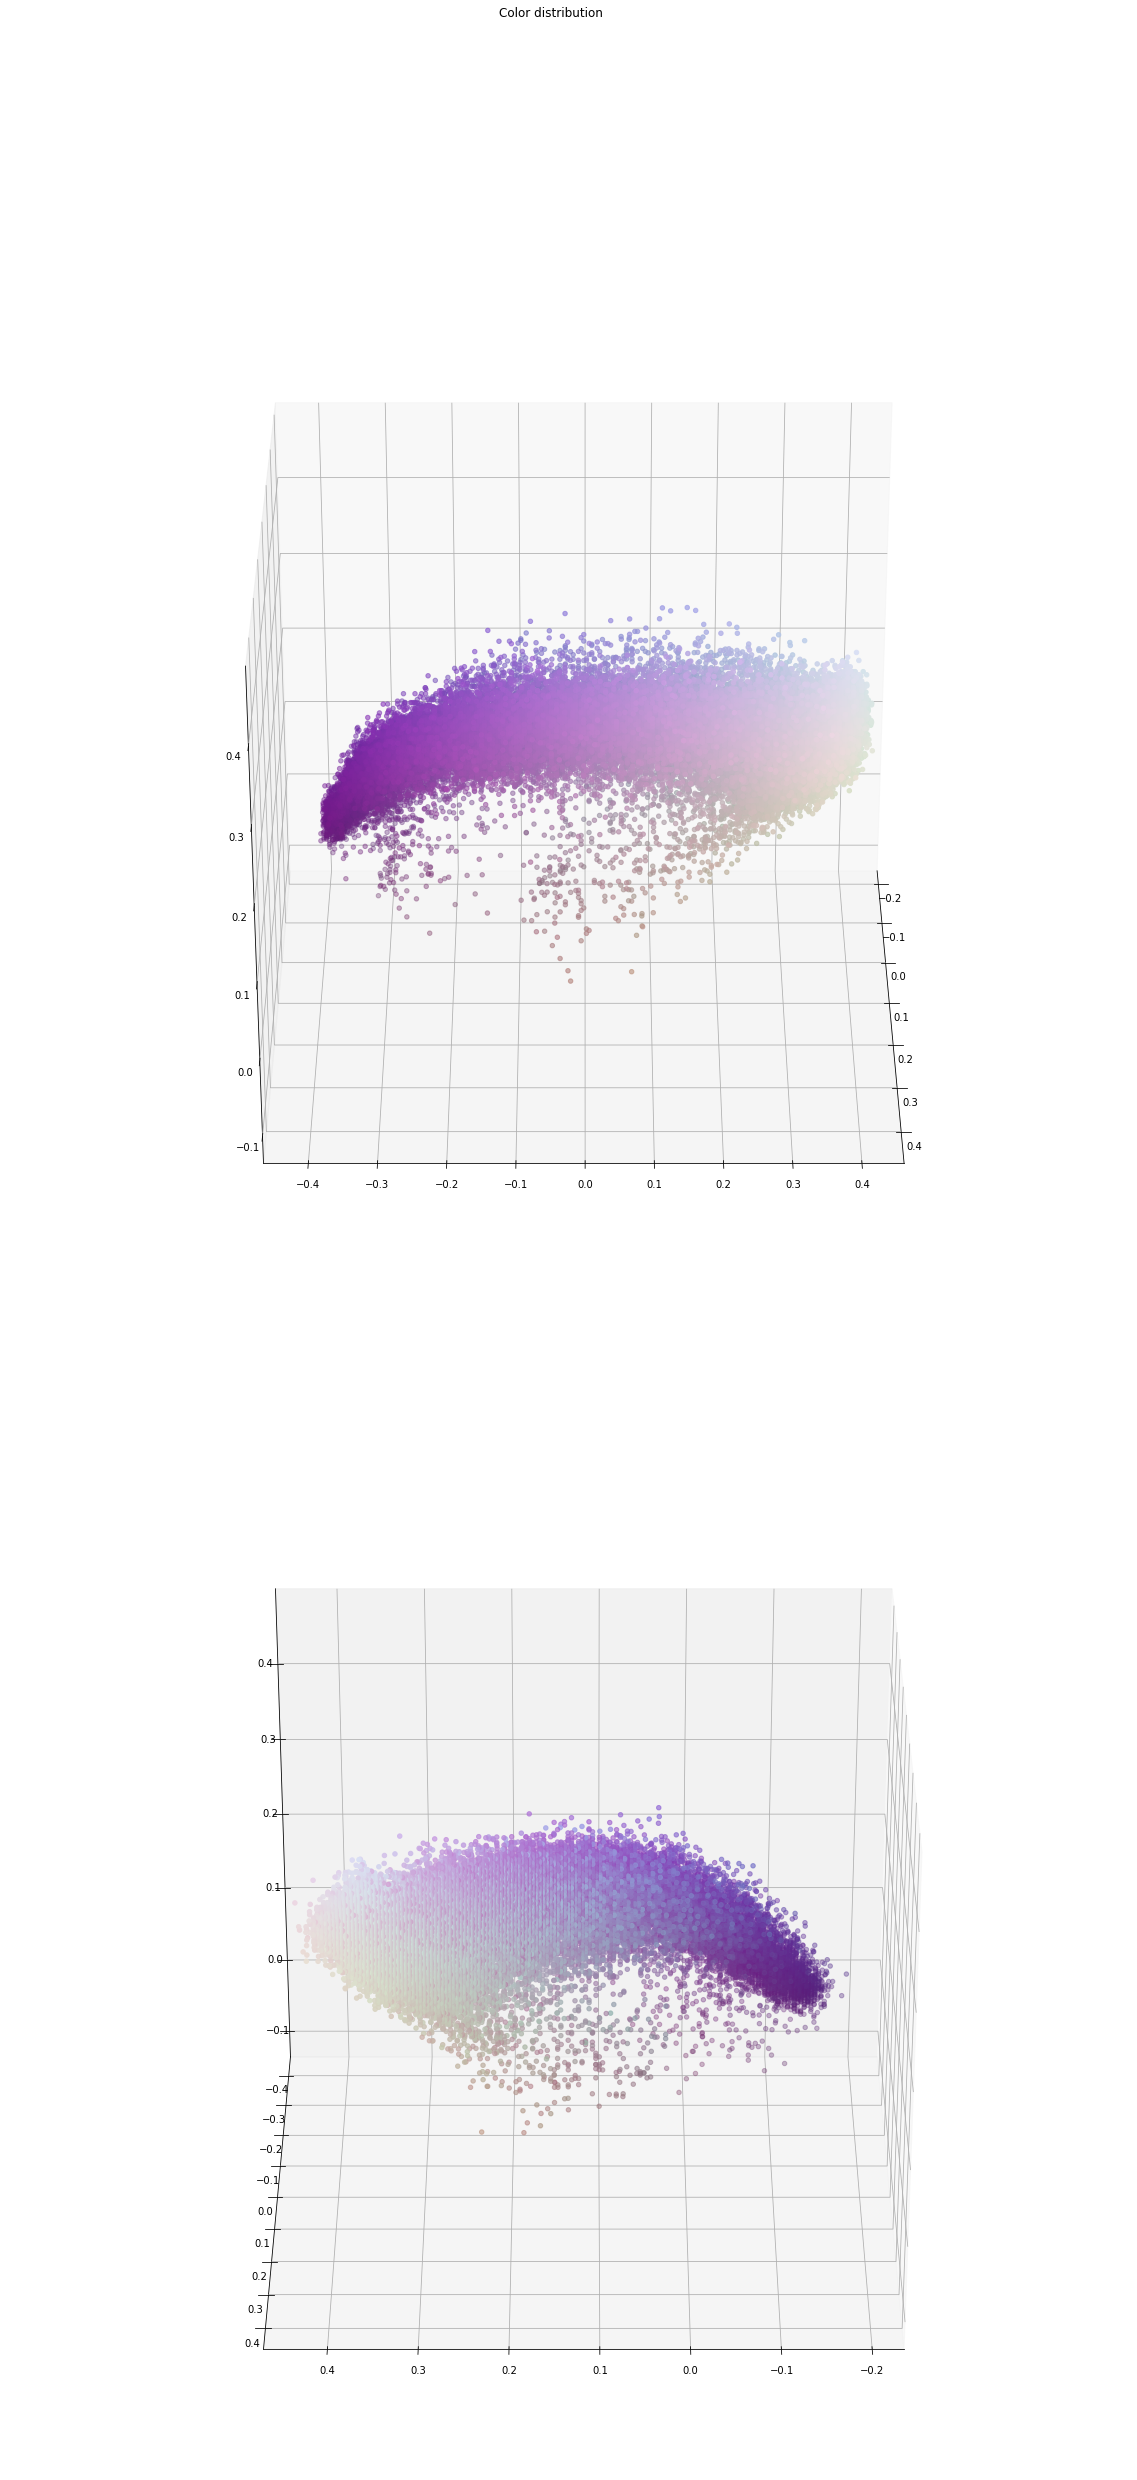

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
sample = train_set.get("7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5")
image = sample["image"]
colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
color_codes = np.apply_along_axis(lambda c: matplotlib.colors.rgb2hex(c / 255.0), 1, colors)
fig = plt.figure(figsize=(20, 40))
fig.suptitle('Color distribution')
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax.view_init(30, 0)
ax.scatter(colors[..., 0] / 255.0 - 0.5, colors[..., 1] / 255.0 - 0.5, colors[..., 2] / 255.0 - 0.5, c=color_codes)
ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.view_init(30, 90)
ax.scatter(colors[..., 0] / 255.0 - 0.5, colors[..., 1] / 255.0 - 0.5, colors[..., 2] / 255.0 - 0.5, c=color_codes)
plt.show()

In [26]:
#sample = train_set.get("7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5")
sample = train_set.__getitem__(0)
image = sample["image"]
pixels = image.reshape(-1, image.shape[2])/255.0
mean = pixels.mean(axis=0)
np.linalg.svd(np.cov(pixels.T))

(array([[ -5.77350269e-01,   8.16496581e-01,  -8.75605293e-17,
           0.00000000e+00],
        [ -5.77350269e-01,  -4.08248290e-01,  -7.07106781e-01,
           0.00000000e+00],
        [ -5.77350269e-01,  -4.08248290e-01,   7.07106781e-01,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00]]),
 array([  6.12634579e-03,   6.29494881e-19,   3.18226293e-51,
          0.00000000e+00]),
 array([[-0.57735027, -0.57735027, -0.57735027,  0.        ],
        [-0.81649658,  0.40824829,  0.40824829, -0.        ],
        [ 0.        , -0.70710678,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [27]:
mask_size = np.empty((0, 2))
for sample in train_set:
    for mask in sample["masks"]:
        sum = mask.sum()
        data = [sum, sum / mask.size]
        mask_size = np.concatenate((mask_size, np.reshape(data, (1, 2))))
print("Mask size: ")
print("Maximum: ", mask_size.max(axis=0))
print("Minimum: ", mask_size.min(axis=0))
print("Mean: ", mask_size.mean(axis=0))
print("Variance: ", mask_size.var(axis=0))

Mask size: 
Maximum:  [  2.81443500e+06   2.13070679e+01]
Minimum:  [  5.35500000e+03   5.10692596e-03]
Mean:  [  1.20309945e+05   8.07196055e-01]
Variance:  [  2.21640391e+10   1.30987155e+00]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# Remember to enable GPU
%matplotlib inline

Using TensorFlow backend.


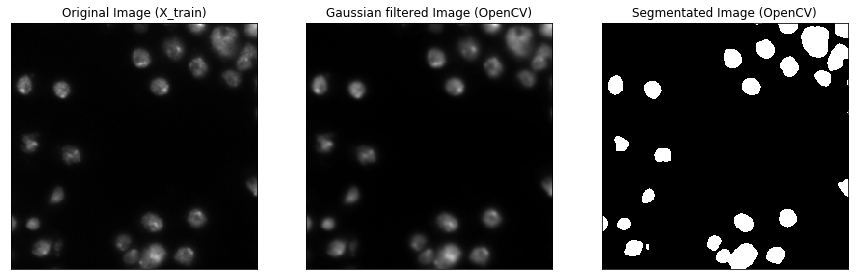

In [4]:
def openCVdemo():
    ID = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
    FILE = "../input/stage1_train/{}/images/{}.png".format(ID,ID)
    img = cv2.imread(FILE,0)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    # Plot Here
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image (X_train)','Gaussian filtered Image (OpenCV)',"Segmentated Image (OpenCV)"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])
openCVdemo()

In [4]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [05:11<00:00,  2.15it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:02<00:00, 30.66it/s]


Done!

x_train (536, 128, 128, 3)
x_test (134, 128, 128, 3)
y_train (536, 128, 128, 1)
y_test (134, 128, 128, 1)


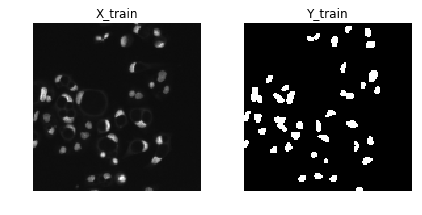

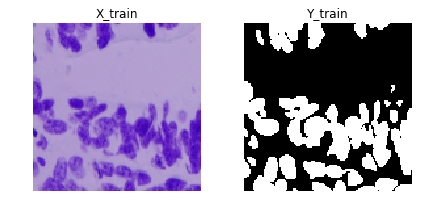

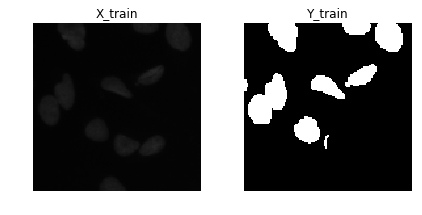

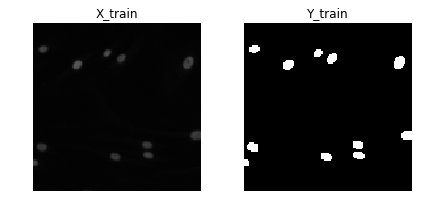

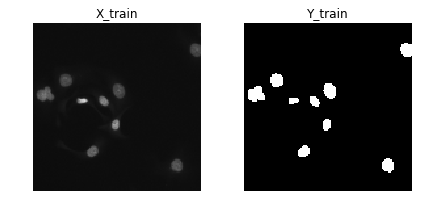

In [5]:
def plotTrainData(a,b):
    for i in range(5):
        ix = random.randint(0, len(train_ids))
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(X_train,Y_train)

In [6]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#RLE encoding for submission
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________


Epoch 00004: val_loss improved from -0.50337 to -0.51301, saving model to model-dsbowl2018-1.h5
Epoch 5/30
536/536 [==============================] - ETA: 49s - loss: -0.5229 - dice_coef: 0.5229 - acc: 0.7808 - mean_squared_error: 0.21 - ETA: 44s - loss: -0.5389 - dice_coef: 0.5389 - acc: 0.8058 - mean_squared_error: 0.18 - ETA: 40s - loss: -0.5777 - dice_coef: 0.5777 - acc: 0.8176 - mean_squared_error: 0.17 - ETA: 37s - loss: -0.5552 - dice_coef: 0.5552 - acc: 0.8111 - mean_squared_error: 0.18 - ETA: 33s - loss: -0.5163 - dice_coef: 0.5163 - acc: 0.7894 - mean_squared_error: 0.20 - ETA: 30s - loss: -0.5282 - dice_coef: 0.5282 - acc: 0.7921 - mean_squared_error: 0.20 - ETA: 27s - loss: -0.5408 - dice_coef: 0.5408 - acc: 0.8006 - mean_squared_error: 0.19 - ETA: 24s - loss: -0.5399 - dice_coef: 0.5399 - acc: 0.7993 - mean_squared_error: 0.19 - ETA: 21s - loss: -0.5579 - dice_coef: 0.5579 - acc: 0.8098 - mean_squared_error: 0.18 - ETA: 19s - loss: -0.5483 - dice_coef: 0.5483 - acc: 0.802

536/536 [==============================] - ETA: 53s - loss: -0.5245 - dice_coef: 0.5245 - acc: 0.7852 - mean_squared_error: 0.21 - ETA: 48s - loss: -0.5068 - dice_coef: 0.5068 - acc: 0.7858 - mean_squared_error: 0.21 - ETA: 43s - loss: -0.5522 - dice_coef: 0.5522 - acc: 0.8042 - mean_squared_error: 0.19 - ETA: 39s - loss: -0.5594 - dice_coef: 0.5594 - acc: 0.8116 - mean_squared_error: 0.18 - ETA: 35s - loss: -0.5660 - dice_coef: 0.5660 - acc: 0.8109 - mean_squared_error: 0.18 - ETA: 32s - loss: -0.5707 - dice_coef: 0.5707 - acc: 0.8157 - mean_squared_error: 0.18 - ETA: 29s - loss: -0.5889 - dice_coef: 0.5889 - acc: 0.8245 - mean_squared_error: 0.17 - ETA: 25s - loss: -0.5941 - dice_coef: 0.5941 - acc: 0.8298 - mean_squared_error: 0.16 - ETA: 22s - loss: -0.5967 - dice_coef: 0.5967 - acc: 0.8282 - mean_squared_error: 0.16 - ETA: 19s - loss: -0.5820 - dice_coef: 0.5820 - acc: 0.8226 - mean_squared_error: 0.17 - ETA: 16s - loss: -0.5836 - dice_coef: 0.5836 - acc: 0.8210 - mean_squared_err

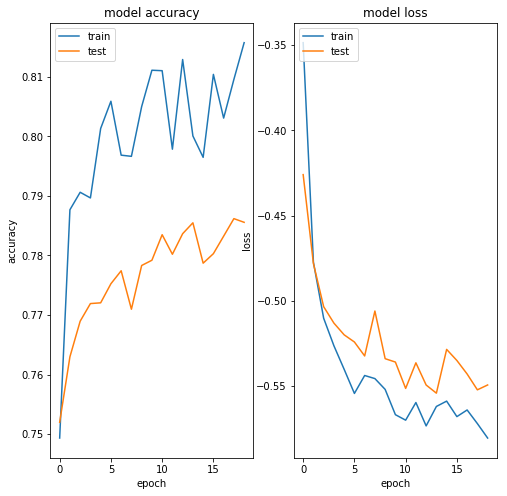

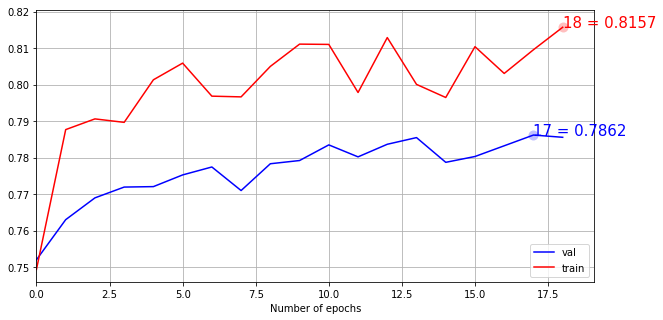

In [8]:
def SIMPLE(a,b,c,d):
    smooth = 1.
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    simple_cnn = Sequential()
    simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),name = 'NormalizeInput'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    # use dilations to get a slightly larger field of view
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
    # the final processing
    simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
    simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
    simple_cnn.summary()
    checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(patience=5, verbose=1)
    simple_cnn.compile(optimizer = 'adam', 
                       loss = dice_coef_loss, 
                       metrics = [dice_coef, 'acc', 'mse'])
    history = simple_cnn.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')],epochs = 30)
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelY
    modelY = simple_cnn
    return modelY
SIMPLE(x_train, y_train,x_test,y_test)

134/134 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 5s 36ms/step


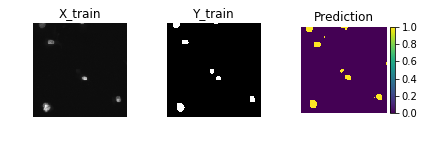

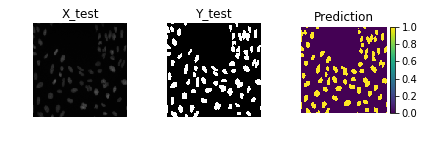

In [10]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()
plotPredictions(x_train,y_train,x_test,y_test,modelY)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (

536/536 [==============================] - ETA: 3:26 - loss: 0.1292 - mean_iou: 0.6580 - acc: 0.94 - ETA: 3:35 - loss: 0.1547 - mean_iou: 0.6584 - acc: 0.93 - ETA: 3:17 - loss: 0.1456 - mean_iou: 0.6587 - acc: 0.94 - ETA: 2:59 - loss: 0.1329 - mean_iou: 0.6591 - acc: 0.94 - ETA: 2:48 - loss: 0.1359 - mean_iou: 0.6596 - acc: 0.94 - ETA: 2:41 - loss: 0.1357 - mean_iou: 0.6601 - acc: 0.94 - ETA: 2:39 - loss: 0.1300 - mean_iou: 0.6607 - acc: 0.95 - ETA: 2:31 - loss: 0.1227 - mean_iou: 0.6612 - acc: 0.95 - ETA: 2:30 - loss: 0.1233 - mean_iou: 0.6617 - acc: 0.95 - ETA: 2:23 - loss: 0.1223 - mean_iou: 0.6622 - acc: 0.95 - ETA: 2:15 - loss: 0.1235 - mean_iou: 0.6626 - acc: 0.95 - ETA: 2:06 - loss: 0.1248 - mean_iou: 0.6631 - acc: 0.95 - ETA: 1:57 - loss: 0.1239 - mean_iou: 0.6635 - acc: 0.95 - ETA: 1:50 - loss: 0.1241 - mean_iou: 0.6639 - acc: 0.95 - ETA: 1:42 - loss: 0.1219 - mean_iou: 0.6643 - acc: 0.95 - ETA: 1:35 - loss: 0.1206 - mean_iou: 0.6647 - acc: 0.95 - ETA: 1:28 - loss: 0.1228 - me

536/536 [==============================] - ETA: 2:16 - loss: 0.0622 - mean_iou: 0.7695 - acc: 0.97 - ETA: 2:09 - loss: 0.0764 - mean_iou: 0.7696 - acc: 0.96 - ETA: 2:10 - loss: 0.0763 - mean_iou: 0.7697 - acc: 0.97 - ETA: 2:02 - loss: 0.0772 - mean_iou: 0.7698 - acc: 0.97 - ETA: 1:59 - loss: 0.0817 - mean_iou: 0.7699 - acc: 0.96 - ETA: 1:58 - loss: 0.0785 - mean_iou: 0.7700 - acc: 0.96 - ETA: 1:52 - loss: 0.0819 - mean_iou: 0.7701 - acc: 0.96 - ETA: 1:47 - loss: 0.0864 - mean_iou: 0.7703 - acc: 0.96 - ETA: 1:43 - loss: 0.0912 - mean_iou: 0.7704 - acc: 0.96 - ETA: 1:39 - loss: 0.0915 - mean_iou: 0.7705 - acc: 0.96 - ETA: 1:33 - loss: 0.0906 - mean_iou: 0.7706 - acc: 0.96 - ETA: 1:29 - loss: 0.0901 - mean_iou: 0.7707 - acc: 0.96 - ETA: 1:26 - loss: 0.0874 - mean_iou: 0.7708 - acc: 0.96 - ETA: 1:21 - loss: 0.0867 - mean_iou: 0.7709 - acc: 0.96 - ETA: 1:17 - loss: 0.0868 - mean_iou: 0.7711 - acc: 0.96 - ETA: 1:13 - loss: 0.0884 - mean_iou: 0.7712 - acc: 0.96 - ETA: 1:09 - loss: 0.0889 - me

536/536 [==============================] - ETA: 2:26 - loss: 0.0463 - mean_iou: 0.8023 - acc: 0.98 - ETA: 2:13 - loss: 0.0504 - mean_iou: 0.8024 - acc: 0.98 - ETA: 2:08 - loss: 0.0497 - mean_iou: 0.8024 - acc: 0.98 - ETA: 2:04 - loss: 0.0546 - mean_iou: 0.8025 - acc: 0.97 - ETA: 2:00 - loss: 0.0602 - mean_iou: 0.8025 - acc: 0.97 - ETA: 1:55 - loss: 0.0641 - mean_iou: 0.8026 - acc: 0.97 - ETA: 1:49 - loss: 0.0652 - mean_iou: 0.8026 - acc: 0.97 - ETA: 1:44 - loss: 0.0653 - mean_iou: 0.8027 - acc: 0.97 - ETA: 1:41 - loss: 0.0675 - mean_iou: 0.8027 - acc: 0.97 - ETA: 1:36 - loss: 0.0689 - mean_iou: 0.8028 - acc: 0.97 - ETA: 1:32 - loss: 0.0731 - mean_iou: 0.8028 - acc: 0.97 - ETA: 1:28 - loss: 0.0727 - mean_iou: 0.8028 - acc: 0.97 - ETA: 1:24 - loss: 0.0722 - mean_iou: 0.8029 - acc: 0.97 - ETA: 1:20 - loss: 0.0741 - mean_iou: 0.8029 - acc: 0.97 - ETA: 1:16 - loss: 0.0743 - mean_iou: 0.8030 - acc: 0.97 - ETA: 1:11 - loss: 0.0740 - mean_iou: 0.8030 - acc: 0.97 - ETA: 1:07 - loss: 0.0731 - me

536/536 [==============================] - ETA: 2:17 - loss: 0.0839 - mean_iou: 0.8196 - acc: 0.96 - ETA: 2:05 - loss: 0.0651 - mean_iou: 0.8196 - acc: 0.97 - ETA: 2:00 - loss: 0.0826 - mean_iou: 0.8196 - acc: 0.96 - ETA: 1:55 - loss: 0.0832 - mean_iou: 0.8196 - acc: 0.96 - ETA: 1:54 - loss: 0.0800 - mean_iou: 0.8197 - acc: 0.96 - ETA: 1:49 - loss: 0.0793 - mean_iou: 0.8197 - acc: 0.96 - ETA: 1:44 - loss: 0.0744 - mean_iou: 0.8197 - acc: 0.96 - ETA: 1:40 - loss: 0.0758 - mean_iou: 0.8197 - acc: 0.96 - ETA: 1:37 - loss: 0.0751 - mean_iou: 0.8197 - acc: 0.96 - ETA: 1:33 - loss: 0.0725 - mean_iou: 0.8198 - acc: 0.97 - ETA: 1:29 - loss: 0.0711 - mean_iou: 0.8198 - acc: 0.97 - ETA: 1:25 - loss: 0.0713 - mean_iou: 0.8198 - acc: 0.97 - ETA: 1:22 - loss: 0.0720 - mean_iou: 0.8198 - acc: 0.97 - ETA: 1:17 - loss: 0.0709 - mean_iou: 0.8199 - acc: 0.97 - ETA: 1:14 - loss: 0.0687 - mean_iou: 0.8199 - acc: 0.97 - ETA: 1:10 - loss: 0.0683 - mean_iou: 0.8199 - acc: 0.97 - ETA: 1:06 - loss: 0.0692 - me

536/536 [==============================] - ETA: 4:00 - loss: 0.0759 - mean_iou: 0.8309 - acc: 0.96 - ETA: 4:02 - loss: 0.0757 - mean_iou: 0.8309 - acc: 0.96 - ETA: 3:54 - loss: 0.0677 - mean_iou: 0.8309 - acc: 0.97 - ETA: 3:47 - loss: 0.0623 - mean_iou: 0.8309 - acc: 0.97 - ETA: 3:35 - loss: 0.0631 - mean_iou: 0.8310 - acc: 0.97 - ETA: 3:29 - loss: 0.0650 - mean_iou: 0.8310 - acc: 0.97 - ETA: 3:19 - loss: 0.0646 - mean_iou: 0.8310 - acc: 0.97 - ETA: 3:13 - loss: 0.0675 - mean_iou: 0.8310 - acc: 0.97 - ETA: 3:03 - loss: 0.0645 - mean_iou: 0.8310 - acc: 0.97 - ETA: 2:56 - loss: 0.0637 - mean_iou: 0.8311 - acc: 0.97 - ETA: 2:47 - loss: 0.0665 - mean_iou: 0.8311 - acc: 0.97 - ETA: 2:41 - loss: 0.0666 - mean_iou: 0.8311 - acc: 0.97 - ETA: 2:33 - loss: 0.0653 - mean_iou: 0.8311 - acc: 0.97 - ETA: 2:25 - loss: 0.0664 - mean_iou: 0.8311 - acc: 0.97 - ETA: 2:18 - loss: 0.0656 - mean_iou: 0.8312 - acc: 0.97 - ETA: 2:10 - loss: 0.0657 - mean_iou: 0.8312 - acc: 0.97 - ETA: 2:03 - loss: 0.0652 - me

536/536 [==============================] - ETA: 4:05 - loss: 0.0616 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:51 - loss: 0.0580 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:44 - loss: 0.0520 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:37 - loss: 0.0543 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:29 - loss: 0.0579 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:24 - loss: 0.0560 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:15 - loss: 0.0592 - mean_iou: 0.8393 - acc: 0.97 - ETA: 3:10 - loss: 0.0606 - mean_iou: 0.8394 - acc: 0.97 - ETA: 3:01 - loss: 0.0601 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:55 - loss: 0.0617 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:46 - loss: 0.0618 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:39 - loss: 0.0627 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:31 - loss: 0.0633 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:24 - loss: 0.0637 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:16 - loss: 0.0621 - mean_iou: 0.8394 - acc: 0.97 - ETA: 2:09 - loss: 0.0624 - mean_iou: 0.8395 - acc: 0.97 - ETA: 2:02 - loss: 0.0618 - me

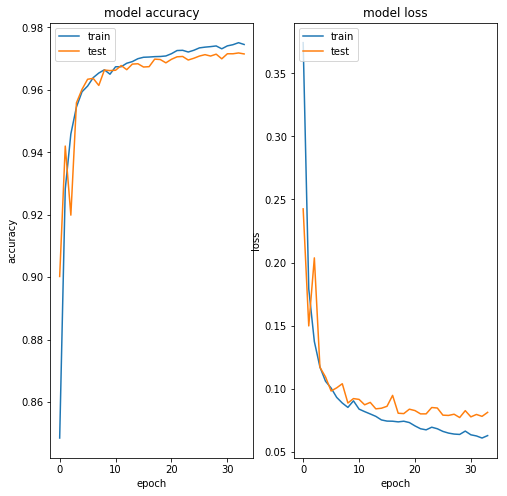

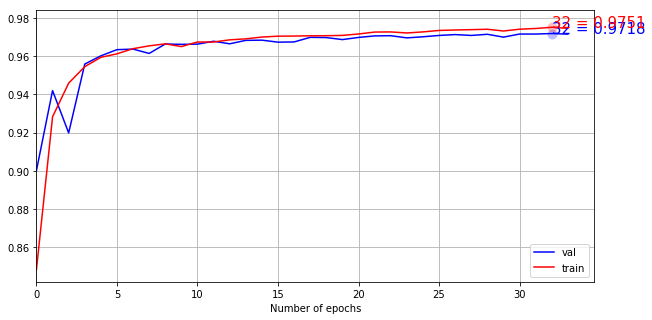

In [11]:
def UNET(a,b,c,d):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
    results = model.fit(a,b,batch_size=16,verbose=1,epochs=40,validation_data=(c,d),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')])
    plot_learning_curve(results)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelZ
    modelZ = model
    return modelZ
UNET(x_train, y_train,x_test,y_test)

134/134 [==============================] - ETA: 14 - ETA: 10 - ETA: 5 - ETA:  - 21s 154ms/step


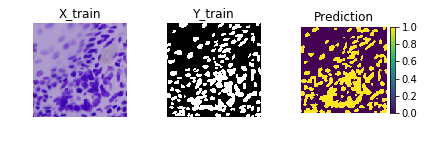

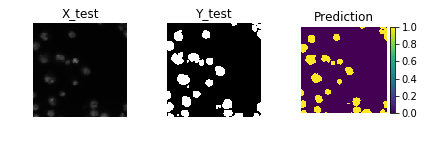

In [12]:
plotPredictions(x_train,y_train,x_test,y_test,modelZ)

In [13]:
#Submit Results for OpenCV Approach
TEST_PATH = '../input/stage1_test/'
test_ids = os.listdir(TEST_PATH)
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*"))[0] for test_id in test_ids]

def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    _, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

segmented = []
for test_image_path in tqdm(test_image_paths):
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)
    segmented.append(mask)

# Submit Results for OpenCV Approach
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
#submission_df.sample(3)
#submission_df.to_csv('modelX.csv', index=False)
#print("\nMethod 1: OpenCV")
#print("Results Saved")

# Submit Results for Deep Learning Approaches
def saveResults(a,b):        
    preds_test = a.predict(b, verbose=1)
    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                           (sizes_test[i][0], sizes_test[i][1]), 
                                           mode='constant', preserve_range=True))
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    # Create submission DataFrame
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(a.name+'.csv', index=False)
    print("Results Saved")
#print("\nMethod 2: Simple CNN")
#saveResults(modelY,X_test)
#print("\nMethod 3: U-Net CNN")
#saveResults(modelZ,X_test)

100%|██████████| 65/65 [00:00<00:00, 72.60it/s]
